In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import os
import datetime as dt
import re

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import ResidualsPlot

In [3]:
# import wiki_nlp and clean
wiki_nlp = pd.read_csv('../NLP/wiki_nlp.csv')
wiki_nlp = wiki_nlp.rename(columns={'this_article_unique_name': 'article_name'})
wiki_nlp.set_index('article_name', inplace=True) #set article name as index
wiki_nlp.fillna(value = 0, inplace=True)
wiki_nlp = wiki_nlp.reset_index()
wiki_nlp.drop(columns=['level_0','Unnamed: 0'], inplace=True, errors='ignore')

In [4]:
# import target (num of lang) from ExtractClean
wiki_feat = pd.read_csv('../ExtractClean/wiki_10feat.csv')
wiki_lang = wiki_feat[['article_name','languages']]
wiki_lang = wiki_lang.rename(columns={'languages': 'lang_total_num_target'})

# join two dataframes
wiki_nlp_comb = wiki_lang.merge(wiki_nlp, left_on='article_name', right_on='article_name')

In [5]:
wiki_nlp_comb = wiki_nlp_comb.reset_index()
wiki_nlp_comb.set_index('article_name', inplace=True) #set article name as index
wiki_nlp_comb.drop(['1858', 'Ice','Dysprosium','Eucalyptus','.uy','2000s in music'], inplace=True, errors='ignore') #outliers 

In [6]:
#normalize all features except languages

normalized_wiki_nlp = (wiki_nlp_comb - wiki_nlp_comb.min()) / (wiki_nlp_comb.max()-wiki_nlp_comb.min())
normalized_wiki_nlp['lang_total_num_target'] = wiki_nlp_comb['lang_total_num_target']

In [7]:
normalized_wiki_nlp.drop(columns=['level_0'], inplace=True, errors='ignore')
normalized_wiki_nlp.sort_values(by='lang_total_num_target',ascending=False).head(10)

,lang_total_num_target,aurelio,padovani,february,june,fascist,war,mussolini,naples,fascism,...,rosson,jorasanko,taltala,calcutta,kmc,bahrenborstel,diepholz,redmond,biologist,obe
article_name,,,,,,,,,,,,,,,,,,,,,
Lubusz Voivodeship,75,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jeans,73,0.0,0.0,0.015504,0.036697,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gamete,69,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Temple in Jerusalem,66,0.0,0.0,0.000000,0.036697,0.0,0.016949,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rosalyn Sussman Yalow,65,0.0,0.0,0.000000,0.036697,0.0,0.016949,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Republic of Genoa,64,0.0,0.0,0.000000,0.036697,0.0,0.059322,0.0,0.625,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pope Nicholas II,63,0.0,0.0,0.000000,0.000000,0.0,0.021186,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gerard Butler,61,0.0,0.0,0.051680,0.045872,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Flame,60,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
normalized_wiki_nlp.shape

(3633, 31301)

In [9]:
normalized_wiki_nlp.dropna(axis='columns',inplace=True)
normalized_wiki_nlp.shape

(3633, 30936)

In [10]:
# Create an empty model
lr_full = LinearRegression()

# Features
X = normalized_wiki_nlp.loc[:, 'aurelio':'obe']

# Target
y = normalized_wiki_nlp['lang_total_num_target']

# Fit  
lr_full.fit(X, y)

# Score
lr_full.score(X, y)

0.9633549700504224

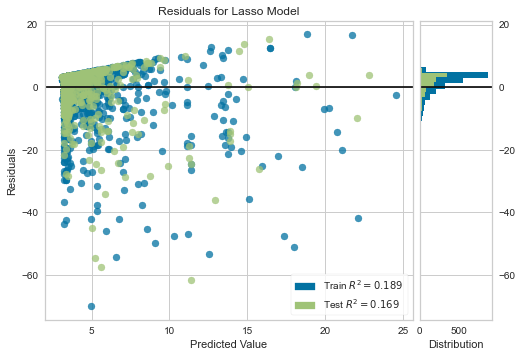

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fb6eb41e9d0&gt;

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = Lasso(alpha=0.04)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [12]:
model.fit(X_train, y_train)
prediction = model.predict(X_test)
residual = abs(y_test - prediction)

residual.sort_values(ascending=False).head(20)

article_name
Giambattista Vico                  54.254516
Henry the Fowler                   52.900348
Flag of South Africa               52.291953
Mondragone                         42.700289
Empire style                       41.278405
FC Sochaux-Montbéliard             38.104201
PAOK FC                            37.357063
Umberto Nobile                     34.235102
Ethiopia national football team    33.061127
Suizhou                            32.476000
Billy Talent                       29.677980
Neuschönau                         28.565716
Dominance (genetics)               27.915486
Priyanka Gandhi                    27.854521
Negus                              27.745147
Poor Folk                          26.944588
Bahrenborstel                      26.879720
Góra                               25.610574
Commerce City, Colorado            25.135627
Mihai Răzvan Ungureanu             24.476000
Name: lang_total_num_target, dtype: float64